# AWS DevDay Seoul 2019
## 모두를 위한 컴퓨터 비전 딥러닝 툴킷, GluonCV 따라하기
## Lab 2.3 Transfer Learning 적용하기 - YOLOv3

<!-- This notebook is based on: https://github.com/zhreshold/ICCV19-GluonCV -->

노트북을 처음 로딩할 때, Kernel로 **conda_mxnet_p36** 을 선택합니다.

### 랩 순서

3. Object Detection - YOLOv3

이번 랩에서는 앞 세션에 이어서 YOLOv3 object detection 모델에 transfer learning을 적용해 보겠습니다.

#### GluonCV와 필요한 python 패키지를 설치합니다.
GluonCV의 model_zoo와 utils 패키지에 대해서는 아래 링크를 참조하세요.
- model_zoo: [https://gluon-cv.mxnet.io/model_zoo/index.html](https://gluon-cv.mxnet.io/model_zoo/index.html)
- utils: [https://gluon-cv.mxnet.io/api/utils.html](https://gluon-cv.mxnet.io/api/utils.html)

In [1]:
# 최초 실행시 GPU(p2/p3) instance에서는 아래 코드로 gluoncv 패키지를 설치하세요.
!pip install --upgrade mxnet-cu100mkl gluoncv
# CPU(c4/c5/m4/m5/t2/t3) instance에서는 아래 코드로 gluoncv 패키지를 설치하세요.
#!pip install --upgrade mxnet-mkl gluoncv

Requirement already up-to-date: mxnet-cu100mkl in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (1.5.0)
Requirement already up-to-date: gluoncv in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (0.5.0)
Requirement not upgraded as not directly required: requests<3,>=2.20.0 in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-cu100mkl) (2.20.0)
Requirement not upgraded as not directly required: numpy<2.0.0,>1.16.0 in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-cu100mkl) (1.17.2)
Requirement not upgraded as not directly required: graphviz<0.9.0,>=0.8.1 in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-cu100mkl) (0.8.4)
Requirement not upgraded as not directly required: Pillow in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from gluoncv) (5.2.0)
Requirement not upgraded as not directly required: scipy in /home/ec2-user/anacond

# Task 3 - Object Detection - YOLOv3

## 데이터 준비

아래 코드를 실행하면, 실습을 위해 미리 준비된 데이터셋에 접근할 수 있습니다.



In [2]:
###############################################
# RecordIO dataset을 읽어오는 부분을 여기에 삽입 필요
###############################################
#url = '../lab1-data-preparation'
#idx_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.idx'
#download(url, path='pikachu_train.rec', overwrite=False)
#download(idx_url, path='pikachu_train.idx', overwrite=False)

In [3]:
import time
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon, nd, image
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils import download, viz
from gluoncv.model_zoo import get_model
from gluoncv.utils import viz, download
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.yolo import YOLO3DefaultTrainTransform
from gluoncv.data.transforms.presets.yolo import YOLO3DefaultValTransform
from gluoncv.data.dataloader import RandomTransformDataLoader
from gluoncv.utils.metrics.voc_detection import VOC07MApMetric, VOCMApMetric
from gluoncv.utils import LRScheduler, LRSequential

다운로드한 데이터셋을 로드해서 확인합니다.

label: [[  15.       199.       284.       327.         2.     ]
 [ 496.       156.       929.       335.         2.     ]
 [ 770.       225.      1021.       449.         2.     ]
 [   2.       215.00002  525.       469.         2.     ]]


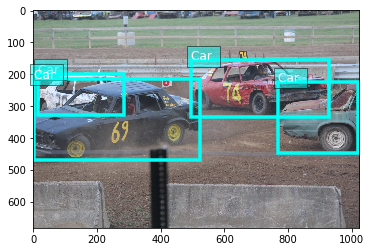

In [4]:
train_dataset = gluoncv.data.RecordFileDetection('train.rec')
val_dataset = gluoncv.data.RecordFileDetection('test.rec')
classes = ['Bird', 'Boat', 'Car', 'Person']
image, label = train_dataset[1]
print('label:', label)
# display image and label
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.show()

## Pre-trained 모델

먼저, 여러 object detection 모델 중에서 `SSD`를 사용해보겠습니다. 빠른 실행을 위해 `darknet53`을 기본으로 하는 `YOLO-v3`를 선택합니다.

`GluonCV Model Zoo`가 지원하는 detection 모델의 전체 목록은 [Model Zoo > Detection](https://gluon-cv.mxnet.io/model_zoo/detection.html) 링크에서 확인할 수 있습니다.

In [5]:
net = gluoncv.model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)


다음으로, output layer를 리셋합니다.

In [6]:
net.reset_class(classes)
# now the output layers that used to map to VOC classes are now reset to distinguish pikachu (and background).

## Fine-tuning은 학습의 새로운 단계

이제 dataloader를 아래 코드와 같이 정의합니다.




In [7]:
data_shape = 416
batch_size = 2
num_workers = 2

def get_dataloader(net, train_dataset, val_dataset, data_shape, batch_size, num_workers):
    """Get dataloader."""
    width, height = data_shape, data_shape

    batchify_fn = Tuple(*([Stack() for _ in range(6)] + [Pad(axis=0, pad_val=-1) for _ in range(1)]))  # stack image, all targets generated
#    print('no random shape loader config.')
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(YOLO3DefaultTrainTransform(width, height, net, mixup=None)),
        batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    val_batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
    val_loader = gluon.data.DataLoader(
        val_dataset.transform(YOLO3DefaultValTransform(width, height)),
        batch_size, False, batchify_fn=val_batchify_fn, last_batch='keep', num_workers=num_workers)
    
    return train_loader, val_loader

train_data, val_data = get_dataloader(
    net, train_dataset, val_dataset, data_shape, batch_size, num_workers)



학습에 가능하면 GPU를 사용할 것을 권해드립니다.


In [8]:
try:
    a = mx.nd.zeros((1,), ctx=mx.gpu(0))
    ctx = [mx.gpu(0)]
except:
    ctx = [mx.cpu()]
net.collect_params().reset_ctx(ctx)


다음으로 trainer, loss와 metric을 정의합니다.



In [9]:
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})

# targets
sigmoid_ce = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
l1_loss = gluon.loss.L1Loss()

# metrics
obj_metrics = mx.metric.Loss('ObjLoss')
center_metrics = mx.metric.Loss('BoxCenterLoss')
scale_metrics = mx.metric.Loss('BoxScaleLoss')
cls_metrics = mx.metric.Loss('ClassLoss')


모든 것이 준비되었으므로 이제 학습을 시작할 수 있습니다. 


In [10]:
epochs = 2
best_map = [0]
for epoch in range(0, epochs):
    tic = time.time()
    btic = time.time()
    mx.nd.waitall()
    net.hybridize(static_alloc=True, static_shape=True)
            
    for i, batch in enumerate(train_data):
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        # objectness, center_targets, scale_targets, weights, class_targets
        fixed_targets = [gluon.utils.split_and_load(batch[it], ctx_list=ctx, batch_axis=0) for it in range(1, 6)]
        gt_boxes = gluon.utils.split_and_load(batch[6], ctx_list=ctx, batch_axis=0)
        sum_losses = []
        obj_losses = []
        center_losses = []
        scale_losses = []
        cls_losses = []
        with autograd.record():
            for ix, x in enumerate(data):
                obj_loss, center_loss, scale_loss, cls_loss = net(x, gt_boxes[ix], *[ft[ix] for ft in fixed_targets])
                sum_losses.append(obj_loss + center_loss + scale_loss + cls_loss)
                obj_losses.append(obj_loss)
                center_losses.append(center_loss)
                scale_losses.append(scale_loss)
                cls_losses.append(cls_loss)
            autograd.backward(sum_losses)
        trainer.step(batch_size)
        obj_metrics.update(0, obj_losses)
        center_metrics.update(0, center_losses)
        scale_metrics.update(0, scale_losses)
        cls_metrics.update(0, cls_losses)
        if i % 1 == 0:
            name1, loss1 = obj_metrics.get()
            name2, loss2 = center_metrics.get()
            name3, loss3 = scale_metrics.get()
            name4, loss4 = cls_metrics.get()                
            print('[Epoch {}][Batch {}], LR: {:.2E}, Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, trainer.learning_rate, batch_size/(time.time()-btic), name1, loss1, name2, loss2, name3, loss3, name4, loss4))
        btic = time.time()

    name1, loss1 = obj_metrics.get()
    name2, loss2 = center_metrics.get()
    name3, loss3 = scale_metrics.get()
    name4, loss4 = cls_metrics.get()
    print('[Epoch {}] Training cost: {:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}'.format(
        epoch, (time.time()-tic), name1, loss1, name2, loss2, name3, loss3, name4, loss4))

[Epoch 0][Batch 0], LR: 1.00E-03, Speed: 0.725 samples/sec, ObjLoss=8147.741, BoxCenterLoss=5.241, BoxScaleLoss=5.946, ClassLoss=4.699
[Epoch 0][Batch 1], LR: 1.00E-03, Speed: 26.837 samples/sec, ObjLoss=4099.626, BoxCenterLoss=8.986, BoxScaleLoss=7.847, ClassLoss=8.517
[Epoch 0][Batch 2], LR: 1.00E-03, Speed: 28.512 samples/sec, ObjLoss=2818.702, BoxCenterLoss=11.222, BoxScaleLoss=7.809, ClassLoss=10.778
[Epoch 0][Batch 3], LR: 1.00E-03, Speed: 28.195 samples/sec, ObjLoss=2118.553, BoxCenterLoss=9.234, BoxScaleLoss=6.522, ClassLoss=9.025
[Epoch 0][Batch 4], LR: 1.00E-03, Speed: 28.491 samples/sec, ObjLoss=1706.479, BoxCenterLoss=8.797, BoxScaleLoss=6.084, ClassLoss=8.657
[Epoch 0][Batch 5], LR: 1.00E-03, Speed: 2.636 samples/sec, ObjLoss=1463.893, BoxCenterLoss=8.206, BoxScaleLoss=5.672, ClassLoss=8.153
[Epoch 0] Training cost: 3.805, ObjLoss=1463.893, BoxCenterLoss=8.206, BoxScaleLoss=5.672, ClassLoss=8.153
[Epoch 1][Batch 0], LR: 1.00E-03, Speed: 6.771 samples/sec, ObjLoss=1306.432,

Fine-tuning의 결과로 얻은 weight 값을 디스크에 저장합니다.

In [11]:
net.save_parameters('yolo3_darknet53_voc_0000.params')


## Fine-tuning한 모델로 예측하기

위에서 fine-tuning한 weight로 성능을 테스트할 수 있습니다. 여러 피카추가 들어있는 테스트 이미지로, 과연 모두 찾을 수 있을지 확인해 보겠습니다.


Shape of pre-processed image: (1, 3, 416, 624)


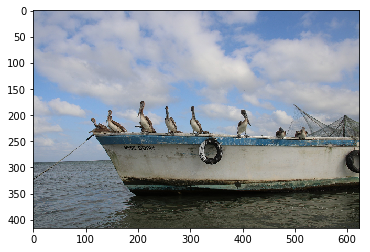

<Figure size 2304x2304 with 0 Axes>

In [13]:
#########################################################################################
# THIS CELL MUST BE FILLED WITH correct YOLOv3 transfer learning prediction code - ignore anything
#########################################################################################
#
#test_url = 'https://raw.githubusercontent.com/zackchase/mxnet-the-straight-dope/master/img/pikachu.jpg'
#download(test_url, 'pikachu_test.jpg')
#net = gluoncv.model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)
#net = gluoncv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes, pretrained_base=False)
#net.load_parameters('yolo3_darknet53_voc.params')
net_name = 'yolo3_darknet53_custom'
model_param_fname = 'yolo3_darknet53_voc_0000.params'
classes = ['Bird', 'Boat', 'Car', 'Person']

#########################################################################
# I want this code to run on CPU too. Tried but couldn't make it work.
ctx = mx.gpu(0)
#########################################################################
    
net = gluoncv.model_zoo.get_model(net_name, classes=classes, ctx=ctx, pretrained_base=False)
net.load_parameters(model_param_fname, ctx=ctx)
net.hybridize()

x, image = gluoncv.data.transforms.presets.yolo.load_test('test_sample_0.jpg', 416)
x = x.as_in_context(ctx)
print('Shape of pre-processed image:', x.shape)
cid, score, bbox = net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes)
plt.figure(figsize=(32,32))
plt.show()


지금까지 `GluonCV`에서 `YOLOv3` 기반의 커스텀 네트워크를 사용해 object detection하는 예제를 알아봤습니다. 수고하셨습니다.
